##### David Kerrigan dwk55, Qi Cheng qxc101, ZiWei Liu zxl486

# Introduction

### The Data
We used data from a 2015 US census extract.  This data contains 72,727 rows and 37 columns which are: CensusTract, State, County, TotalPop, Men, Women, Hispanic, White, Black, Native, Asian, Pacific, Citizen, Income, IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty, Professional, Service,Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, MeanCommute, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, and Unemployment.  The data was found at https://www.kaggle.com/muonneutrino/us-census-demographic-data 


All ethnic demographic measurements are in percent of population, income is average yearly income in USD, poverty is the percentage of population under the poverty line, and unemployment is unemployment rate.


### The Causal DAG
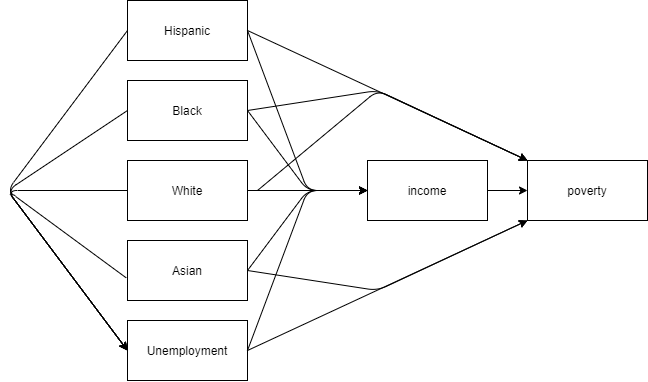
A brief explanation: ethnic demographic affects unemployment rate, average income, and poverty level.  In addition, unemployment affects both income and poverty.  Finally, average income effects poverty level.  

### The Causal Question
We will use both IP weighting and Standardization to find causal effects in the dataset.  These approaches are necessary to negate confounding and selection bias in the causal structure.  We want to find which technique produces a more accurate and consistent result for this dataset and why this technique works better.

### Study and Analysis
We will measure the following causal effects: 
$$Unemployment \rightarrow Income $$$$Unemployment \rightarrow Income \,|\, Poverty = high $$ 
We will use both causal risk ratio and causal risk difference.  In addition, the two statistical approaches we use will generate confidence intervals and standard error, which can be compared to find the more consistent estimator.  The data itself does not contain a measurement of causal effects, so we must consult external sources for causes of income inequality in the United States.  For this purpose, we will use census.gov's anaysis of its own extremely broad data.

### Some Background Knowledge

#### Causal Effect Measures
The two expressions I will use are causal risk ratio and causal difference:
$$\frac{E[Y|A=high]}{E[Y|A=low]}$$$$E[Y|A=high]-E[Y|A=low]$$
<br>
On a side note, the features of the data are all continuous valued.  However, in order to define a contrast in the treatment $A$ I decided to seperate values by high = "above the mean" and low = "below the mean".  However, the rest of the variables remain continuous.


#### Conditional Exchangibility
It's important to note that these expressions are really measures of *associational* risk ratio and risk difference.  The true measures of causal risk ratio and risk difference are:
$$\frac{E[Y^{high}]}{E[Y^{low}]}$$$$E[Y^{high}]-E[Y^{low}]$$
Where, for example, $E[Y^{a}]$ represents the expected outcome in the entire population given a treatment $a$, and $E[Y|A=a]$ represents the expected outcome in the population which received the treatment $a$.  It's important to note that associational measures do not necessarily equal causal measures because of bias in the causal structure, namely through selection bias, measurement bias, treatment-confounder feedback, etc.  However, if confounding can be accounted for, the two measures should be equal.  


#### Positivity & Well Defined Interventions
Since the dataset is *observed* data, and not a randomized experiment performed with the intent of measuring causal effects, we need to satisfy to other conditions.  Firstly, given treatment $A$ and confounder $L$, positivity is the following:
$$Pr[A=a|L=l]>0$$ for all a and for l in which $$Pr[L=l]>0$$  Since our values are continuous and our dataset is extremely large -- remember it's 72,727 entries -- this is true.
Secondly, well defined interventions describes the condition that $A=a$ holds equal value across the dataset.  Does unemployment have the same causal effects in each measurement of our dataset?  Given the knowledge of confounders $L$ we believe so.

# IP Weighting

My assignment was to find causal effects in the following system:
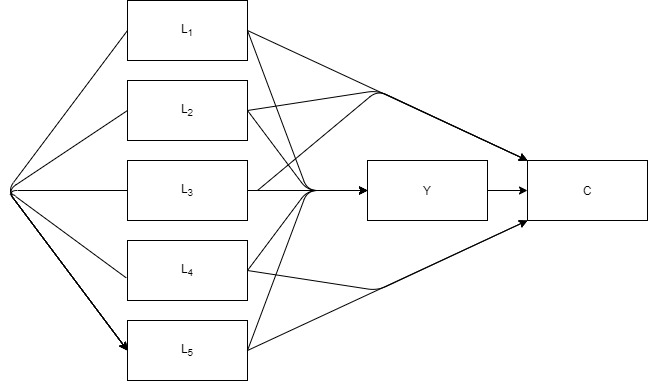
Remember that $L_1,L_2,L_3,L_4$ is black, white, asian, hispanic, $A$ is unemployment and C is poverty.  Originally, I planned to only measure the effect of unemployment on income given high poverty, but as an expansion I decided to measure the effects of each confounder as well.  
$$A \rightarrow Y \,|\,L_1,L_2,L_3,L_4,C=high$$
<br>
Where A can be any of black, white, asian, hispanic, or unemployment. 

Let's continue by simply plotting a weighted least squares regression for each factor of $Y$ given a restriction $C=high$ gives this:

In [2]:
from helpers import *
import matplotlib.pyplot as plt

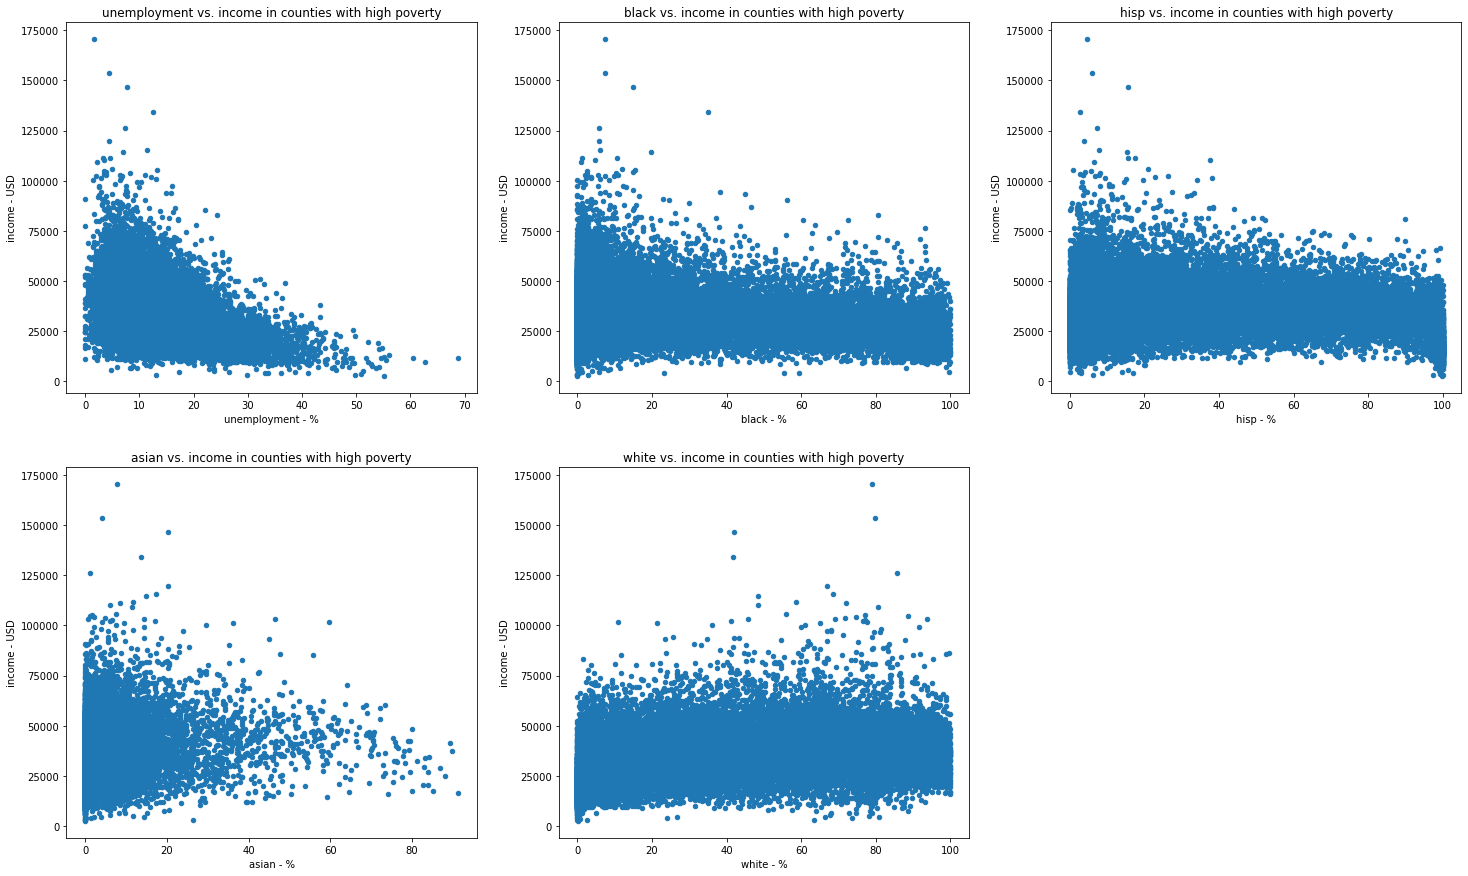

In [4]:
fig = plt.figure();fig.set_figheight(15);fig.set_figwidth(25);plt.subplot(2, 3, 1);scatterTreatment('unemployment');plt.subplot(2, 3, 2);scatterTreatment('black');plt.subplot(2, 3, 3);scatterTreatment('hisp');plt.subplot(2, 3, 4);scatterTreatment('asian');plt.subplot(2, 3, 5);scatterTreatment('white');plt.show()

Unfortunately, we cannot draw a causal conclusion by finding $E[Y|A,L]$ from this data because our DAG contains confounding and selection bias.  The confounding bias in our DAG is illustrated by:
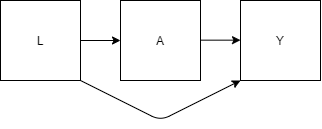
IP Weighting each census measurement will result in a pseudo-population in which the causal effect from $L\rightarrow A$ is removed.  This is done by finding the value of $Pr[A|L]$ for all $L$. We do this by by fitting a regression model and calculating an estimate $\widehat{Pr}[A|L]$ for all $L$.  Then we find a value:
$$W_a=\frac{1}{\widehat{Pr}[A|L]}$$ for each confounder $L$.
<br><br>Now we need to adjust for selection bias.  The following shows selection bias in our DAG:
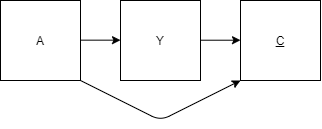
Since we condition on $C=high$ we need to remove the causal effects from confounders and treatment into censoring $C$.  This is done by fitting a regression for $Pr[C=high|A,L]$ for each $A,L$.  We use this regression to find an estimate $\widehat{Pr}[C=high|A,L]$.  Then we find a value:
$$W_c=\frac{1}{Pr[C=high|A,L]}$$ for each $A,L$.  

Finally, find $$W_cW_a=W_c*W_a$$
Here is a summary of the IP weights for:
$$A=unemployment,L_1=black,L_2=white,L_3=hisp,L_4=asian$$
$$A=black,L_1=unemployment,L_2=white,L_3=hisp,L_4=asian$$
$$A=hisp,L_1=black,L_2=white,L_3=unemployment,L_4=asian$$
$$A=asian,L_1=black,L_2=white,L_3=hisp,L_4=unemployment$$
$$A=white,L_1=black,L_2=unemployment,L_3=hisp,L_4=asian$$

In [3]:
unemployment = getWeights('unemployment');black = getWeights('black');hisp = getWeights('hisp');asian = getWeights('asian');white = getWeights('white')

unemployment Wc*Wa weights
 min   mean    max
------------------
1.24   11.85   18061.98


black Wc*Wa weights
 min   mean    max
------------------
1.23   34.94   42696.88


hisp Wc*Wa weights
 min   mean    max
------------------
1.21   35.46   7184.97


asian Wc*Wa weights
 min   mean    max
------------------
1.40   25.30   1105.60


white Wc*Wa weights
 min   mean    max
------------------
1.41   12.37   17677.03




Finally, the causal effects can be found by fitting a regression model using the IP Weights $W_cW_a$.  In other words, $$E[Y|A,C=low]=\theta_0+\theta_1*A$$  
With this regression we can now find an estimate for $\widehat{E}[Y|A=high,C=low]$ and $\widehat{E}[Y|A=low,C=low]$. Using these conditional expectations our causal measures can be found via the equations presented earlier. 

In addition, as weighted linear regression performs very poorly in the presence of outliers, IP weighting requires a type of regression that accounts for data corruption from outliers, .  Unfortunately, this kind of robust regression does not work on huge data sets so I used both standard regression and robust regression on a smaller sampled dataset with $N=10,000$ and where the length of the data is $~40,000$.  Here's a brief explanation of how this system works:  
<br>Robust regression uses a different fitting criterion than WLS.  One form, M-Estimation is a form of maximum likelihood estimation in which we have a linear fit:
$$y_i=a+\beta_1x_{i1}+...+\beta_kx_{ik}+e_i=x'_i\beta$$
And an estimation of the model:
$$\hat{y_i}=a+b_1x_{i1}+...+b_kx_{ik}+e_i=x'_ib$$
With residual:
$$e_i=y_i-\hat{y}_i$$
We must minimize this objective function over b to find a robust fit:
$$\sum_{i=1}^n\rho (e_i)=\sum_{i=1}^n\rho (y_i-x'_ib)$$
<br><br>
Lastly, note that even though the results were derived from a *selected* portion of the data $C=high$, these results are not affected by selection bias and should be representative of the entire study population.<br>
Here is the regressions for our main measurement:
$$E[Y|unemployment,C=high]$$

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.332e+04    136.064    318.396      0.000    4.31e+04    4.36e+04
x1          -615.7338     12.875    -47.824      0.000    -640.969    -590.498
casual risk ratio: 0.8293860083532701 +/- 0.0006601809543211546
casual risk difference: -6521.720475006874 +/- 25.23541947204876


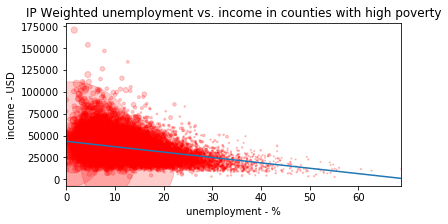

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.652e+04    737.332     63.090      0.000    4.51e+04     4.8e+04
x1          -813.0245     55.483    -14.654      0.000    -921.769    -704.280
casual risk ratio: 0.783648469489938 +/- 0.0027344719214725606
casual risk difference: -8603.83388435124 +/- 108.7440524146349


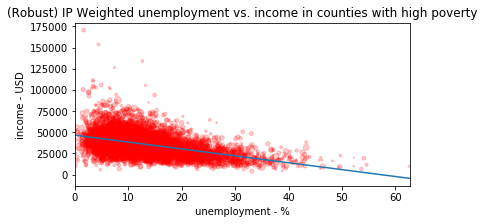

In [4]:
vals = plotWeightedFit('unemployment',unemployment);n=plotRobustSample('unemployment',unemployment)

And the auxiliary measurements I was curious about:
$$E[Y|black,C=high]$$
$$E[Y|hisp,C=high]$$
$$E[Y|asian,C=high]$$
$$E[Y|white,C=high]$$

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.898e+04     76.637    508.683      0.000    3.88e+04    3.91e+04
x1           -90.6383      5.846    -15.506      0.000    -102.096     -79.181
casual risk ratio: 0.8812661312687317 +/- 0.0002980119800167955
casual risk difference: -4564.9139214478055 +/- 11.45754830423239


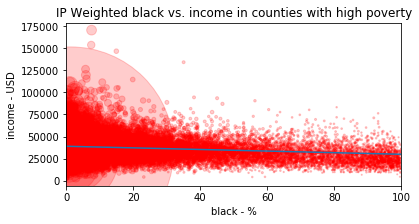

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.927e+04    360.947    108.800      0.000    3.86e+04       4e+04
x1           -94.0732     11.678     -8.056      0.000    -116.961     -71.185
casual risk ratio: 0.8774834411777114 +/- 0.0005910810784336564
casual risk difference: -4744.069481357488 +/- 22.88776090481285


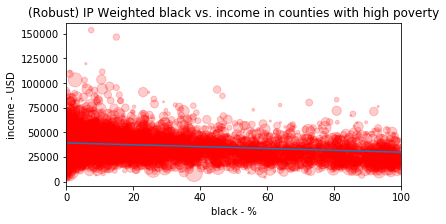

In [5]:
n=plotWeightedFit('black',black);n=plotRobustSample('black',black)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.652e+04     76.049    480.233      0.000    3.64e+04    3.67e+04
x1            46.5291      5.203      8.943      0.000      36.331      56.727
casual risk ratio: 1.0679532626469752 +/- 0.0002767355600253396
casual risk difference: 2504.116516785689 +/- 10.19786334971861


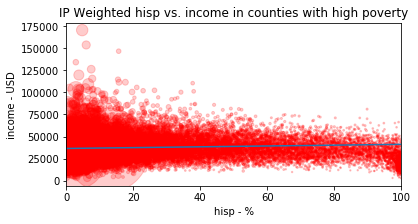

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.664e+04    192.378    190.455      0.000    3.63e+04     3.7e+04
x1            47.4894      6.115      7.766      0.000      35.503      59.475
casual risk ratio: 1.0693752881667458 +/- 0.0003241413206907282
casual risk difference: 2565.3323216779245 +/- 11.98597121154559


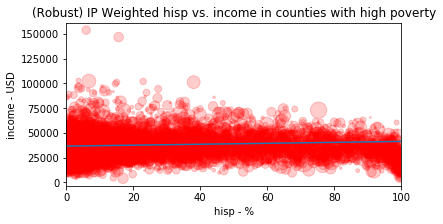

In [6]:
n=plotWeightedFit('hisp',hisp);n=plotRobustSample('hisp',hisp)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.618e+04     72.483    499.147      0.000     3.6e+04    3.63e+04
x1           216.7646     10.073     21.520      0.000     197.021     236.508
casual risk ratio: 1.0702098109388682 +/- 0.0005434552316662763
casual risk difference: 2550.657694610498 +/- 19.743227474759266


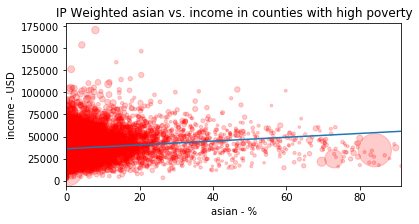

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.608e+04    128.566    280.621      0.000    3.58e+04    3.63e+04
x1           291.7375     24.772     11.777      0.000     243.185     340.290
casual risk ratio: 1.0945023245990748 +/- 0.0013382629454946108
casual risk difference: 3428.5973157137414 +/- 48.55292991054006


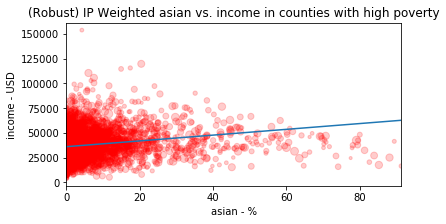

In [7]:
n=plotWeightedFit('asian',asian);n=plotRobustSample('asian',asian)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.026e+04     92.063    328.738      0.000    3.01e+04    3.04e+04
x1           133.2870      2.262     58.916      0.000     128.853     137.721
casual risk ratio: 1.2350433526005955 +/- 0.00013662474078322048
casual risk difference: 7628.521661758969 +/- 4.434266202661206


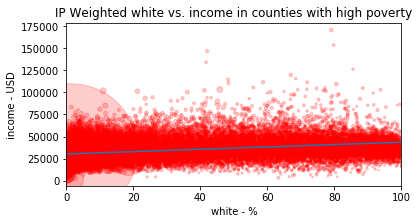

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.081e+04    971.738     31.703      0.000    2.89e+04    3.27e+04
x1           123.0260     15.360      8.010      0.000      92.922     153.130
casual risk ratio: 1.2136927481193496 +/- 0.0009169578062122633
casual risk difference: 7015.685845382388 +/- 30.104380979102388


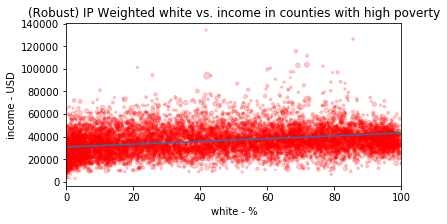

In [8]:
n=plotWeightedFit('white',white);n=plotRobustSample('white',white)

## Quick Analysis
Now we can actually evaluate the qualitative accuracy of these last four results of $ethnicity \rightarrow income$.  Here is a diagram from census.gov:
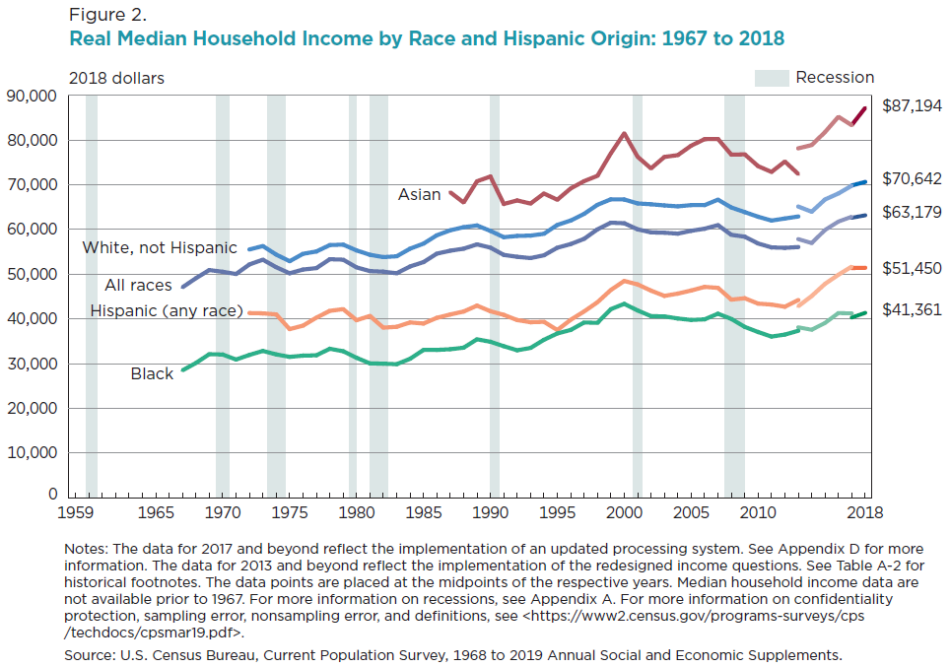
The census data shows that in the year 2015, the ethnicities with with highest household income to lowest household incomes were asian, white, hispanic, and black.  Similarly, in the weighted regression fits I found that the ethnicites with most positive to most negative effect on income were asian, white, hispanic, and black.  Therefore my data is qualitatively accurate relevant to this US Census extract.
 

# Standardization
In observational studies, investigators often use IP weighting or standardization to obtain analytical effect estimates. In the following section we used standardization to estimate the average causal effect of unemployment ($A$, treatment) on income ($Y$, output). Recall that confounder $L$ is a combination of black, white, asian, and hispanic population percentage, and all of them are continuous variables. Therefore, for this high dimensional dataset with mulitple confounders and mulitple levels, we used a slightly modified method of standaradizing the mean outcome to the confounder distribution described in the textbook.

The original method consists of four steps: expansion of dataset, outcome modeling, prediction, and standardization by average.  Expansion of dataset means duplicating the original dataset twice to obtain a 3-block table. Maintain the first block as is. Set all values in the treatment variable, which is unemployment in our context, to 0 in the second block and set them to 1 in the third block. Delete the values in output $Y$ in the second and third block. A treatment times confounder ($A \times L$) term is added to make the model saturated and then a linear regression model is fitted to the table. The model parameters are used to predict the outcome estimations for the second and third block. The standardized mean outcome of the untreated ($A = 0$) is computed by taking the average of all predicted outcome values in the second block, and the standardized mean outcome of the treated ($A = 1$) is computed by taking the average of all predicted outcome values in the third block.

Since the outputs $Y$ in the second and third block are deleted, only the first block (the original data) contributes to the linear regression modeling. Therefore, we modified the above method to simplify the computational steps. First, we fitted a linear regression model using the original data and the $A \times L$ term. Since our treatment variable $A$, unemployment percentage, is a continuous variable, we used a threshold of 9% to discretize the data. All counties with unemployment rate below the mean are assigned as 0 (low unemployment), and all those above are assigned as 1 (high unemployment). We then used the fitted model to predict outcome estimations for the untreated and treated, and finally, obtained the standardized mean outcomes of the untreated and treated by taking the average of predicted outcome estimations from the second and third block respectively. 

Once we obtained the standardized mean outcome, we compute the casual effect measures using causal risk ratio and causal risk difference in the formula given below: <br>

$$\frac{E(Y|A=high,L)}{E(Y|A=low,L)}$$

$$ E(Y|A=high,L)-E(Y|A=low,L) $$ 
To analyze the standard error and confidence interval of our causal effect measures, we used N-bootstrap resampling to sample the original data with replacement 100 times. $N = 100$ is a delibrately considered choice given that we have a relatively large dataset ($n = 72727$). In each sample, some incidences might be selected repeatedly and some may not be existed at all. We computed the causal effect measures for each bootstrap sample, and found the standard deviation of these effect measures. Finally, we computed a 95% confidence interval of the effect measures by $C.I. = \mu \pm 1.96 \times \frac {\sigma}{\sqrt{N}}$, where $\mu$ is the mean of effect measures, $\sigma$ is the standard deviation of effect measures, and $N$ is the total number of bootstrap samples. 

## Analysis
In our program, we implemented the standardization causal inference technique to eliminate confounding bias. There are two main function we would use to get the desired causal measurements. The first function is called standardization. This function takes two inputs, dataset and a value for decision boundary to define low unemployment rate and high unemployment rate. The output of this function is the casual effect measurements, causal risk ratio and casual risk difference, and Standardized Mean Outcome (SMO) for different treatement values (low and high unemployment for this dataset). 

For demo purpose, It is shown below that the function will output causal risk ratio as 0.73, causal difference as -16688.44, SMO for A = 1 as 45955.61, and SMO for A = 0 as 62644.06 with A being the treatment, or unemployment in this case.

In [18]:
from data import giveData
from stand import *
data = giveData();r=np.array(Standardization(data,9.0)).astype(str);print("causal effect ratio "+r[0]+", causal effect difference "+r[1]+", SMO A=1 "+r[2]+", SMO A=0 "+r[3])

causal effect ratio 0.7335988982159298, causal effect difference -16688.446407399075, SMO A=1 45955.612853758925, SMO A=0 62644.059261158


To get confidence intervals and standard errors, we implemented the second function, bootstrap with replacement to calculate confidence intervals. The function takes two inputs, the number of boxes and a value for decision boundary. The output of the function is the average causal risk ratio, standard error of risk ratio, the average causal difference, and the standard error of risk difference. The output lines showed strandardized mean for casual risk ratio and diference and its confidence interval for bootstrapping with 100 boxes with decision boundary as 10% unemployment rate. The output graph causal risk ratio and difference for each boxes.

This code cell, we used bootstrap to measure the causal effect of unemployment rate to average income. The measurements are causal risk ratio and causal risk difference with $ \pm 1.96 \times standard \space error $ as 95% confidence interval. The measurements for bootstrap 100 boxes are printed below.

0.95 confidence interval for risk ratio is 0.7131899485715821 +/- 0.0005141339859516495
0.95 confidence interval for risk difference is -17711.643465352656 +/- 36.31471929039722


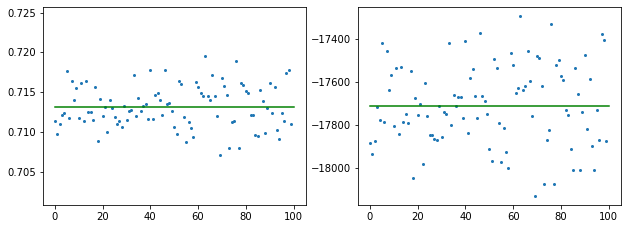

In [14]:
bootStrap100()

The figure above shows the causal effect measures for 100 bootstrap samples, with the left subplot being causal risk ratio and the right being causal risk differece. The causal effect measures are computed using standardized mean outcomes for the treated and untreated according to the equations specified in Section 3.

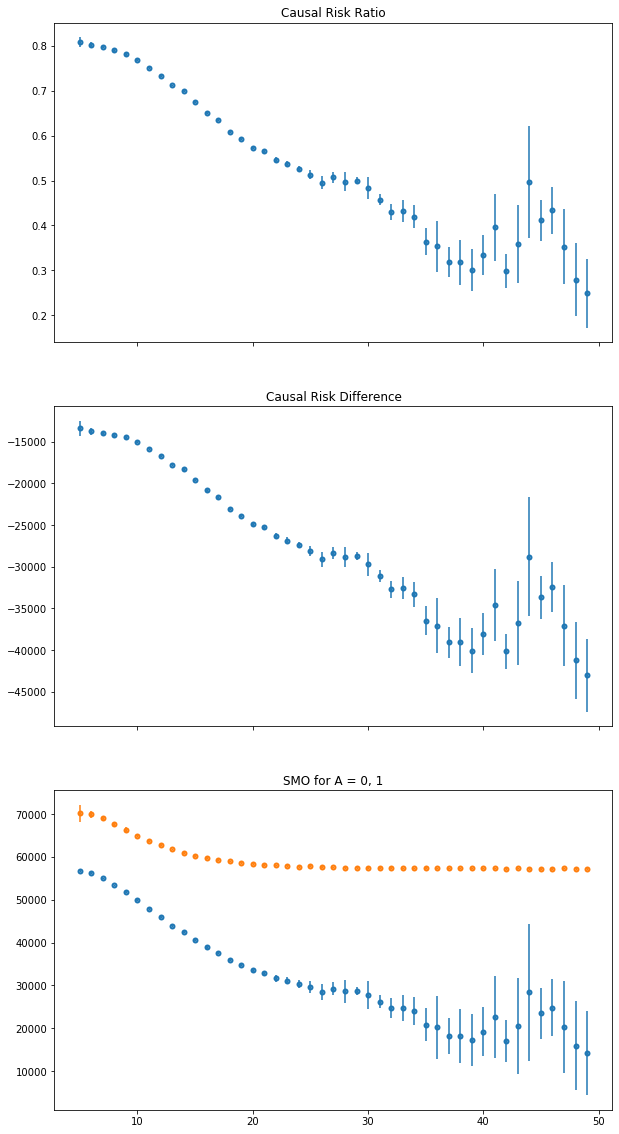

In [15]:
bootStrapMultiple()

The figure above shows the change in causal effect measures when we vary the threshold for discretizing the unemployment rate $A$. All previous results are generated using a threshold of 9% -- the mean of our data's unemployment. However, we are also interested in the changes in effect measures when we vary the threshold. Therefore we varied the threshold from 2% to 47%, with an increment of 1, and generated the figure above. For each data point, we used bootstrapping technique to generate a confidence interval for each causal effect measure.

In the figure, the x axis is the threshold for unemployment rate from 2 to 47. The subplot on the left represents the causal risk ratio of high unemployment rate versus low unemployment rate on average income. The middle subplot represents the causal risk difference. The subplot on the right shows the standardized mean outcomes of high unemployment rate on income ($E(Y|A=high,L)$) in red and low unemployment rate on income ($E(Y|A=low,L)$) in blue. Confidence intervals are also included as error bars in the figure. 

It can be observed that a decreasing trend exists as the threshold increases. When the threshold is below 10, there are only marginal changes in the causal effect measures. When the threshold is greater than 10, the effect measures starts decreasing sharply. The error bars also becomes extremely large as the threshold increasing to a unreasonably large value. Thus we believe that the choice of a threshold at 9% is reasonable and using a threshold above that introduces large bias. 

# Conclusion

Here are the resulting causal effects found in the two approaches:

In [5]:
ipResults = vals;standResults = {'ratio':0.7602464394531729,'difference':-20551.740605253515,'ratioConf':0.0013199556549996852,'differenceConf':113.14695877766826}

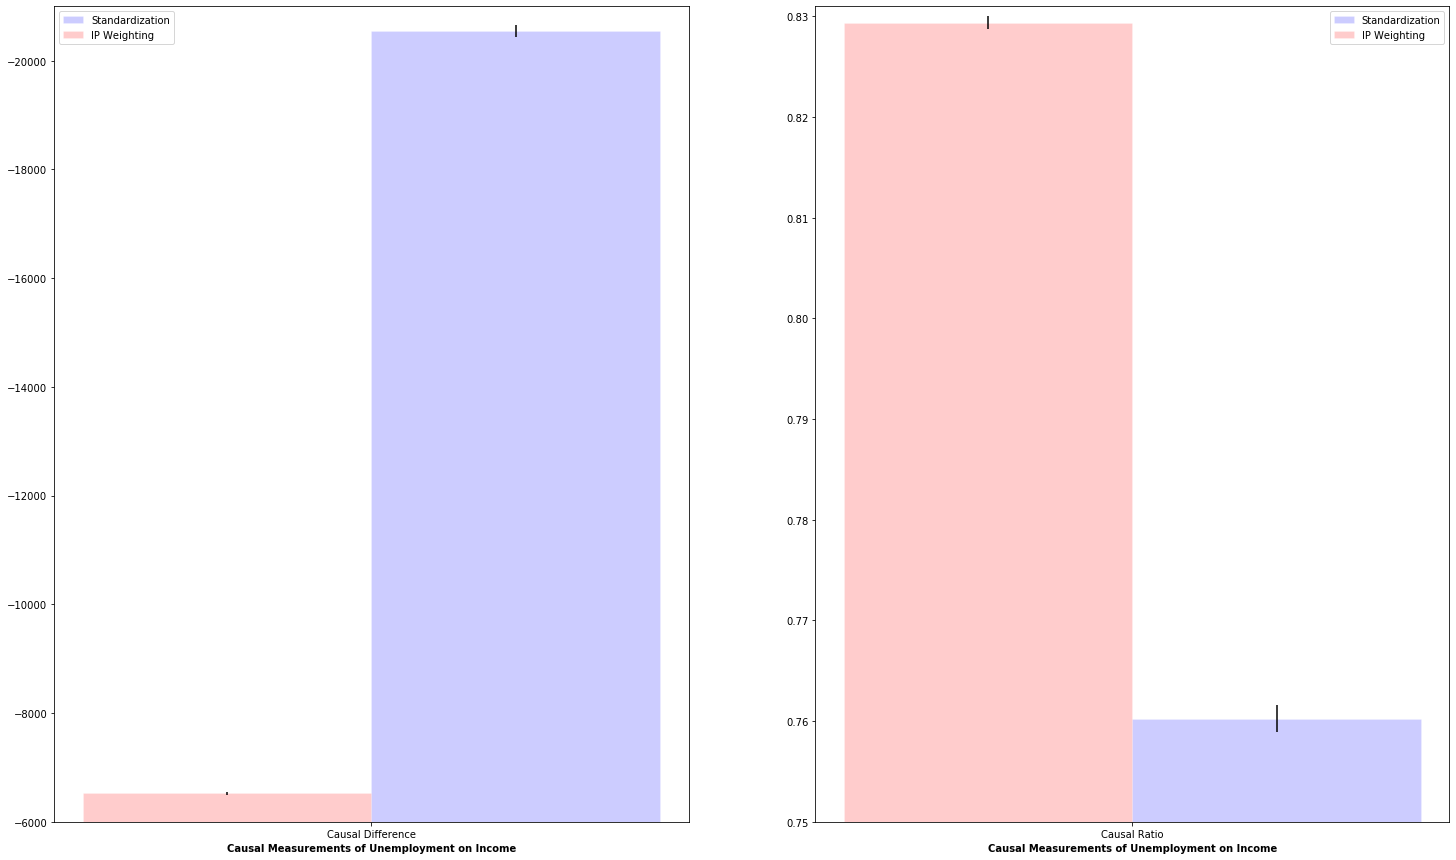

In [6]:
resultGraphs(ipResults,standResults)

Since the IP Weighting produced a narrower confidence interval for both causal measures, we conclude that IP weighting gives a more consistent estimate of causal effects with multiple levels of confounding and selection bias.

An explanation for why this is the case:  Standardization and IP Weighting both fit outcome regressions to the outcome of the causal relationship.  However, IP Weighting assigns each point a "weight" to account for possible sources of bias in the data.  This weight reduces the spread of the relationship and allows for a narrower confidence interval.  Since standardization is based on unweighted regression -- which is used to measure the standardized mean outcome and therefore causal measures -- the confidence interval cannot be as narrow.

The differences found in these two estimation techniques can be described mainly by their regression fits -- if no outcome model was used they will be equivalent -- In IP Weighting $$Pr[A=a,C=0|L]$$ And in standardization $$E[Y|A=a,C=0,L=l]$$
Generally, if the causal effect estimates found by the two procedures differ greatly in magnitude and direction, one or both of the models was misspecified.  Here, our measures were quite similar in magnitude and direction for both causal measures.


# References
[1] J. Fox and S. Weisberg, Robust Regression in R. 2018.


[2]Slides from class


[3]Hernán MA, Robins JM (2020). Causal Inference: What If. Boca Raton: Chapman & Hall/CRC. Chapter 13 (Page 26-28)